# Agrupamiento
Un algoritmo de agrupamiento (en inglés, clustering) es un procedimiento de agrupación de una serie de vectores de acuerdo con un criterio. Esos criterios son por lo general distancia o similitud. La cercanía se define en términos de una determinada función de distancia, como la euclídea, aunque existen otras más robustas o que permiten extenderla a variables discretas. La medida más utilizada para medir la similitud entre los casos es la matriz de correlación entre los nxn casos. Sin embargo, también existen muchos algoritmos que se basan en la maximización de una propiedad estadística llamada verosimilitud.

## Análisis del Problema
El conjunto de datos corresponde al tráfico de dispositivos conectados a la red inalambrica y a que aplicaciones se conectaron. Se busca analizar el patrón de las aplicaciones y agruparlas por las mas usadas, las que se usaron mas o menos, y las menos usadas. Esta información me permitirá tomar decisiones sobre poder bloquear el acceso a ciertas aplicaciones o si se necesita hacer una descarga previa de ciertos archivos que fueron muy descargados.

![Autos ROC](img/trafico.jpg)

## Entendimiento de los Datos

El conjunto de datos contiene las siguientes variables:
- Application: aplicación usada
- Destination: URL de página visitada
- Protocol: protocolo de comunicación
- Port: puerto usado en la comunicación
- % Usage: porcentaje de uso
- Usage: uso en bytes
- Sent: cantidad de bytes enviados
- Received: cantidad de bytes recibidos
- Flows: flujo
- Active time: tiempo de actividad
- #clients: numero de clientes conectados

## Exploración de los Datos

In [10]:
#librerías utilizadas
library(lattice)
library(reshape2)
library(ggplot2)
library(qcc)

In [11]:
#Evitar mostrar warning messages
options(warn=-1)

In [12]:
#cargue el archivo a una variable que se llame trafico usando la función read.csv
trafico <- read.csv('traffic-2.csv')

#sobreescriban las columnas Region y Channel con el factor de esa columna
#ventas$Channel <- factor(ventas$Channel)
#ventas$Region <- factor(ventas$Region)

#Utilice la función str() para ver la estructura del conjunto de datos:
str(trafico)

'data.frame':	54 obs. of  11 variables:
 $ Application: Factor w/ 25 levels "amazon.com","Antivirus updates",..: 18 18 23 15 12 4 13 17 13 5 ...
 $ Destination: Factor w/ 38 levels "","18.144.27.14",..: 5 12 1 1 1 24 31 1 35 1 ...
 $ Protocol   : Factor w/ 3 levels "-","TCP","UDP": 2 2 1 1 1 2 2 1 2 1 ...
 $ Port       : Factor w/ 6 levels "-","22","443",..: 5 5 1 1 1 6 3 1 3 1 ...
 $ X..Usage   : num  29.6 6.4 4.9 4.3 4.3 3.8 3.7 2.8 2.4 2.4 ...
 $ Usage      : int  6677775 1440558 1108022 974385 959030 857840 835665 624284 541974 537111 ...
 $ Sent       : int  67559 12351 3212 98304 38328 61445 6764 49799 2293 14905 ...
 $ Received   : int  6610216 1428207 1104810 876081 920702 796395 828901 574485 539681 522206 ...
 $ Flows      : int  126 205 1 72 2682 27 114 634 113 1083 ...
 $ Active.time: Factor w/ 40 levels "1 hour","1.3 hours",..: 26 31 40 4 21 12 20 13 4 10 ...
 $ X..clients : int  1 2 1 3 18 2 2 18 2 21 ...


La mayoría de las ventas se registraron en la región #3 (otra región), mientras que la mayoría de las  ventas se hicieron por medio del canal # 1 (Horeca), tal como se puede apreciar en los siguientes gráficos:

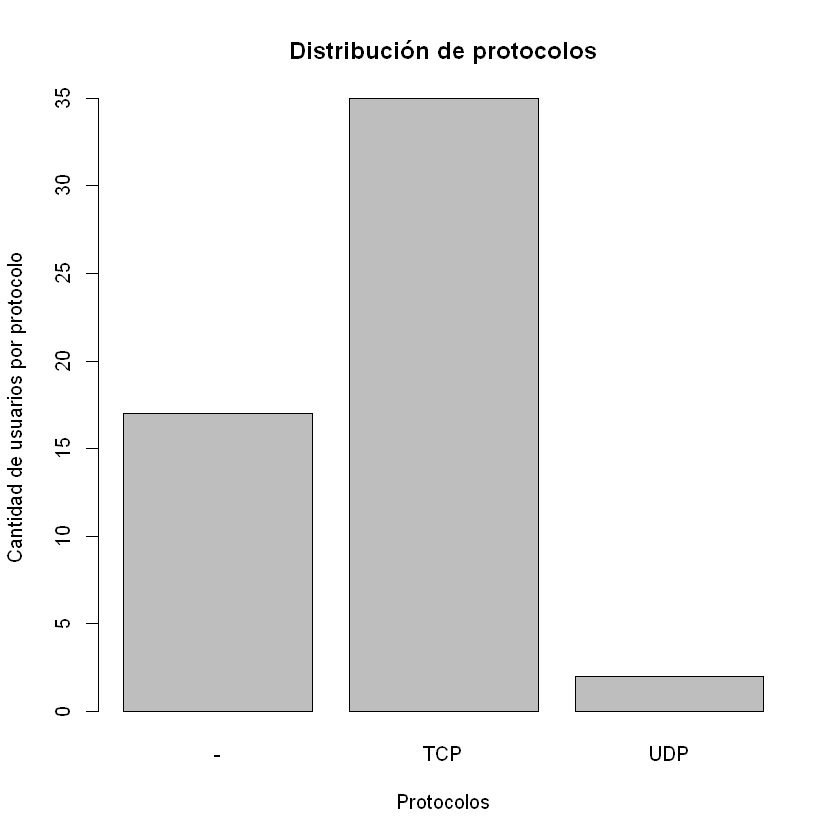

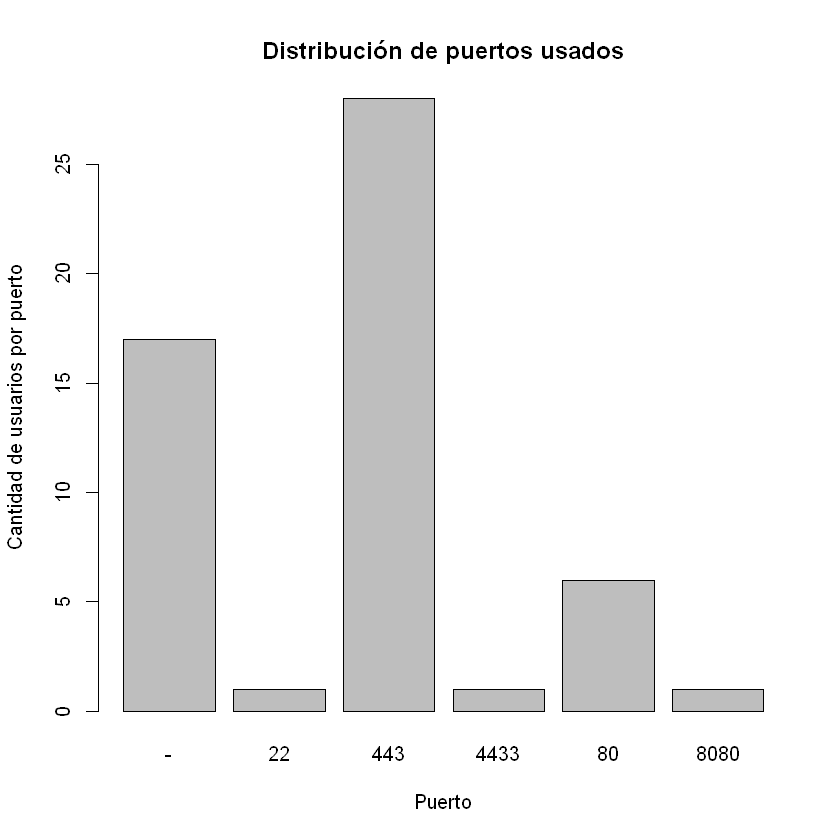

In [13]:
barplot(table(trafico$Protocol),
        main = 'Distribución de protocolos',
        xlab = 'Protocolos',
        ylab = 'Cantidad de usuarios por protocolo')

barplot(table(trafico$Port),
        main = 'Distribución de puertos usados',
        xlab = 'Puerto',
        ylab = 'Cantidad de usuarios por puerto')

Using Application, Destination, Protocol, Port, Active.time as id variables


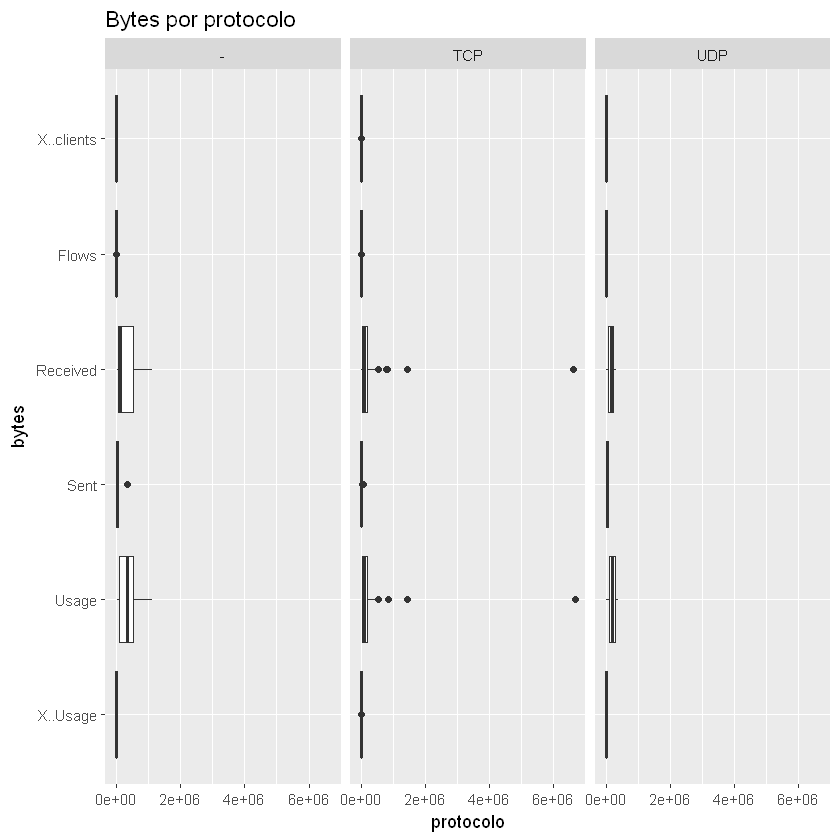

In [20]:
bxplt <- ggplot(data = melt(trafico), aes(x= variable, y = value))
bxplt <- bxplt + geom_boxplot()
bxplt <- bxplt + facet_wrap(~Protocol)
bxplt <- bxplt + coord_flip()
bxplt <- bxplt + labs(x = 'bytes', y  = 'protocolo')
bxplt <- bxplt + ggtitle('Bytes por protocolo')
bxplt

## Modelo de Minería de Datos
Para agrupar a las aplicaciones con base al uso, vamos a utilizar solo las variables Usage, Sent, Received, Flows.
En este caso, vamos a intentar agrupar las aplicaciones en 3 grupos diferentes.

In [22]:
modelo.agrupacion <- kmeans(trafico[,c(6:9)], centers = 3)

In [23]:
#predecir utilizando el modelo para agregar una variable nueva llamada 'cluster' al conjunto de datos
trafico$cluster <- modelo.agrupacion$cluster

#convertir la variable nueva a un factor
trafico$cluster <- factor(trafico$cluster)

## Evaluación

Al hacer un análisis de pareto sobre los grupos creados, se puede apreciar que los grupos #2 y #3 son los que tienen mayor cantidad de clientes asignados: en ellos se agrupa el 74.32%

Estos grupos grandes pueden representar al consumidor promedio, aquellos que no muestran patrones significativamente diferentes a los otros clientes.

   
Pareto chart analysis for table(trafico$cluster)
     Frequency  Cum.Freq. Percentage Cum.Percent.
  2  43.000000  43.000000  79.629630    79.629630
  3  10.000000  53.000000  18.518519    98.148148
  1   1.000000  54.000000   1.851852   100.000000

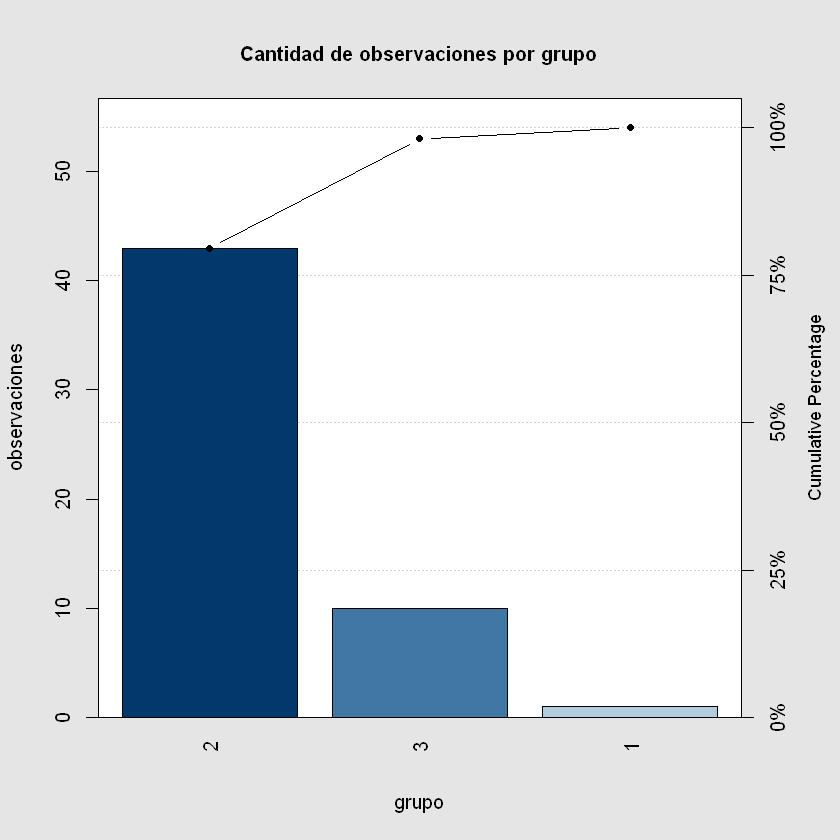

In [24]:
pareto.chart(table(trafico$cluster),
             main = 'Cantidad de observaciones por grupo',
             xlab = 'grupo',
             ylab = 'observaciones')

In [26]:
by(trafico, trafico$cluster, summary)

trafico$cluster: 1
              Application                        Destination Protocol   Port  
 Software updates   :1    b1.download.windowsupdate.com:1    -  :0    -   :0  
 amazon.com         :0                                 :0    TCP:1    22  :0  
 Antivirus updates  :0    18.144.27.14                 :0    UDP:0    443 :0  
 CDNs               :0    audio-sp-sjc.pscdn.co        :0             4433:0  
 Encrypted TCP (SSL):0    az764295.vo.msecnd.net       :0             80  :1  
 Facebook           :0    cloud.r-project.org          :0             8080:0  
 (Other)            :0    (Other)                      :0                     
    X..Usage        Usage              Sent          Received      
 Min.   :29.6   Min.   :6677775   Min.   :67559   Min.   :6610216  
 1st Qu.:29.6   1st Qu.:6677775   1st Qu.:67559   1st Qu.:6610216  
 Median :29.6   Median :6677775   Median :67559   Median :6610216  
 Mean   :29.6   Mean   :6677775   Mean   :67559   Mean   :6610216  
 3rd Qu.:

Las principales características de cada grupo son:

Grupo #1: (Grupo con más % de uso)

- Solo una observación.
- Aplicación usada: Software updates.
- Protocolo: TCP.
- Puerto: 80.
- % Uso(media): 29.6%
- Active time: 3.5 horas.

Grupo #2: (Grupo con menos % de uso)

- 43 observaciones.
- Aplicación más usada: Software updates (23).
- Protocolo más usado: TCP (30).
- Puerto mas usado: 443 (26).
- % Uso(media): 0.57%
- Active time más usado: 8 minutos (3).

Grupo #3: (Grupo con % de uso intermedio)

- 10 observaciones.
- Aplicación más usada: Miscellaneous secure web (2).
- Protocolo más usado: TCP (4).
- Puerto mas usado: 443 (2).
- % Uso(media): 3.73%
- Active time más usado: 10 minutos (2).


## Resultados

El algoritmo de minería de datos utilizado pudo encontrar características muy específicas para dividir el tráfico de acuerdo al uso, y formar grupos interesantes para analizar su comportamiento. El grupo 1, que es el de mayor % uso con 29.6%, solo corresponde a una observación, pero tiene 3.5 horas de tiempo de actividad. El grupo 3, que es el grupo intermedio tiene 3.73% de % de uso, con tiempo de actividad que mas se repite de solo 10 minutos en 2 observaciones. Por último, el grupo 2 es el que tiene menos % de uso con 0.57%, lo que corresponde a un tiempo de actividad mas frecuente de 8 minutos en 3 observaciones.